In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import os, re, time, json
import PIL.Image, PIL.ImageFont, PIL.ImageDraw
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
print("Tensorflow version " + tf.__version__)

Tensorflow version 2.3.0


In [ ]:
tf.config.experimental.list_physical_devices() 

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU')]

In [ ]:
tpu = tf.distribute.cluster_resolver.TPUClusterResolver() # TPU detection
tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
strategy = tf.distribute.experimental.TPUStrategy(tpu)
print("Number of accelerators: ", strategy.num_replicas_in_sync)

INFO:tensorflow:Initializing the TPU system: grpc://10.103.190.74:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.103.190.74:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


Number of accelerators:  8


In [ ]:
BATCH_SIZE = 16*strategy.num_replicas_in_sync
LEARNING_RATE = 0.01
LEARNING_RATE_EXP_DECAY = 0.6 if strategy.num_replicas_in_sync == 1 else 0.7

In [ ]:
strategy.num_replicas_in_sync

8

In [ ]:
import cv2
from imutils import paths
import os
from keras.preprocessing.image import img_to_array

data=[]
labels=[]
i=1

imagePaths = sorted(list(paths.list_images("/content/drive/My Drive/ds/dataset")))
for imagePath in imagePaths:
  print(i)
  i+=1
  image = cv2.imread(imagePath)
  image = cv2.resize(image,(50, 50))
  image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  image = img_to_array(image)
  data.append(image)
  label = imagePath.split(os.path.sep)[-2]
  label = 1 if label == "with_mask" else 0
  labels.append(label)

In [ ]:
import numpy as np
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)

In [ ]:
data.shape

(0,)

In [ ]:
# This model trains to 99.4% accuracy in 10 epochs (with a batch size of 64)  

def make_model():
    model = tf.keras.Sequential(
      [
        
        tf.keras.layers.Conv2D(32, (5, 5), input_shape = (50, 50, 1), activation = 'relu'), # no bias necessary before batch norm
        tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
        
        tf.keras.layers.Conv2D(64, (5, 5), activation = 'relu'),
        tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
        
        tf.keras.layers.Conv2D(128, (5, 5), activation = 'relu'),
        tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(units = 512, activation = 'relu'),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
      ])

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
     # Going back and forth between TPU and host is expensive. Better to run 128 batches on the TPU before reporting back.
    return model
    
with strategy.scope():
    model = make_model()

# print model layers
model.summary()

# set up learning rate decay
lr_decay = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: LEARNING_RATE * LEARNING_RATE_EXP_DECAY**epoch,
    verbose=True)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 46, 46, 32)        832       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 23, 23, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 19, 19, 64)        51264     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 9, 9, 64)          0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 5, 5, 128)         204928    
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 2, 2, 128)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 512)              

In [ ]:
VAL_PCT = 0.1  
val_size = int(len(data)*VAL_PCT)
print(val_size)

train_X = data[:-val_size]
train_y = labels[:-val_size]

test_X = data[-val_size:]
test_y = labels[-val_size:]

455


In [ ]:
EPOCHS = 30
steps_per_epoch = len(data)//BATCH_SIZE
print("Steps per epoch: ", steps_per_epoch)

import time
start_time=time.time()
history = model.fit(train_X,train_y, steps_per_epoch=steps_per_epoch, epochs=EPOCHS)
print("--- %s seconds ---" % (time.time() - start_time))

Steps per epoch:  35
Epoch 1/30
 1/35 [..............................] - ETA: 1:00 - loss: 0.6926 - accuracy: 0.5254WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0022s vs `on_train_batch_end` time: 0.0187s). Check your callbacks.


35/35 [==============================] - ETA: 0s - loss: 0.5952 - accuracy: 0.6713WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0016s vs `on_test_batch_end` time: 0.0165s). Check your callbacks.


35/35 [==============================] - 7s 204ms/step - loss: 0.5952 - accuracy: 0.6713 - val_loss: 1.2792 - val_accuracy: 0.0879
Epoch 2/30
35/35 [==============================] - 1s 30ms/step - loss: 0.4445 - accuracy: 0.7984 - val_loss: 1.7656 - val_accuracy: 0.1473
Epoch 3/30
35/35 [==============================] - 1s 31ms/step - loss: 0.2766 - accuracy: 0.8851 - val_loss: 0.9456 - val_accuracy: 0.5824
Epoch 4/30
35/35 [==============================] - 1s 30ms/step - loss: 0.2071 - accuracy: 0.9226 - val_loss: 0.9088 - val_accuracy: 0.6308
Epoch 5/30
35/35 [==============================] - 1s 31ms/step - loss: 0.1476 - accuracy: 0.9439 - val_loss: 1.0646 - val_accuracy: 0.6374
Epoch 6/30
35/35 [==============================] - 1s 31ms/step - loss: 0.1573 - accuracy: 0.9409 - val_loss: 1.3692 - val_accuracy: 0.5604
Epoch 7/30
35/35 [==============================] - 1s 31ms/step - loss: 0.1534 - accuracy: 0.9402 - val_loss: 0.7461 - val_accuracy: 0.7143
Epoch 8/30
35/35 [=====

In [ ]:
from keras.preprocessing import image
import cv2
test_image = cv2.imread('/content/drive/My Drive/ds/dataset/without_mask/0_0_aidai_0136.jpg')
test_image=cv2.resize(test_image,(50,50))
test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2GRAY)
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
result = model.predict(test_image)
if result[0][0] == 1:
    prediction = 'mask'
else:
    prediction = 'no mask'
print(prediction)

no mask


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 46, 46, 32)        832       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 23, 23, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 19, 19, 64)        51264     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 9, 9, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 5, 5, 128)         204928    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 2, 2, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 512)               0

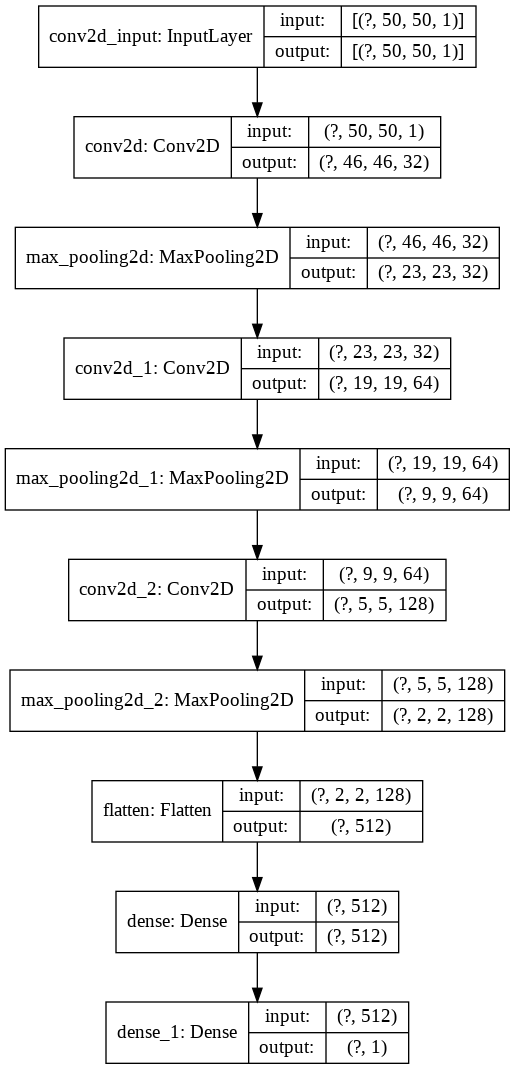

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model,  show_shapes=True, show_layer_names=True)